In [1]:
import numpy as np
from numpy import random

import pandas as pd
import matplotlib.pylab as plt
import ot
import ot.plot
import cvxpy as cp

import scipy.stats as stats
import seaborn as sns
import scipy.special as sps
import time as t

# STEPS
1. [Setup](#Setup)
2. [Barycentric Projection](#(1)-Barycentric-Projection)
3. [Get Optimal Weights](#(2)-Optimal-Weights)
4. [Complete Function](#Complete-Function)
5. [Utils](#Utils)
6. [Examples](#Examples)
7. [To-do](#TO-DO)

## Setup

In [2]:
n1 = n2 = 100
dim = 3

covmat = np.zeros((dim, dim))
np.fill_diagonal(covmat, 1)

covmat2 = np.full((dim, dim), 0.3)
np.fill_diagonal(covmat2, 1)

covmat3 = np.full((dim, dim), 0.5)
np.fill_diagonal(covmat3, 1)

covmat4 = np.full((dim, dim), 0.8)
np.fill_diagonal(covmat4, 1)

a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2

control1 = random.multivariate_normal(mean = [20, 20, 20], cov = covmat4, size = n1)
control2 = random.multivariate_normal(mean = [100, 100, 100], cov = covmat4, size = n1)
control3 = random.multivariate_normal(mean = [50, 50, 50], cov = covmat3, size = n1)
controls = [control1, control2, control3]

TARGET = random.multivariate_normal(mean = [25]*dim, cov = covmat, size = n1)

## Functions

### (1) Barycentric Projection
`baryc_proj` calculates the conditional expectation of each column of the transport plan and outputs the transport map. 
<br>

NOTE: we may consider keeping the distance matrix calculation outside of this function for convenience

In [3]:
def baryc_proj(source, target):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)# try emd
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap)
    
    return(OTmap)

### (2) Optimal Weights
`to_optimize` defines the function that we want to minimize; it is for use within optimization with CVXPY. Refer to (2.7) in DSC<br>
`get_optimal_weights` defines the actual optimization with CVXPY

In [26]:
def to_optimize(lambdas):
    
    ans = []
    for i in range(J):
        temp = lambdas[i] * (G_list[i] - globtarget)
        ans.append(sum(sum(temp**2)))
    
    return sum(ans) / n

In [6]:
def get_optimal_weights(Glist):
        
    mylambda = cp.Variable(J)

    objective = cp.Minimize(to_optimize(mylambda))
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    weights = mylambda.value
    
    return(weights)

# Complete Function
The complete function takes in the target and controls and outputs the optimal weights and actual projection. It requires the globalization of variables n, d, J and G_list, which are useful outside of the function as well.

In [27]:
def DSCreplication(target, controls):
    
    global n, d, J, globtarget
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    globtarget = target

    # Barycentric Projection
    global G_list
    G_list = []
    for i in range(len(controls)):
        G_list.append(baryc_proj(target, controls[i]))
    
    
    # Obtain optimal weights(to_optimze needs to be pre-defined)
    weights = get_optimal_weights(G_list)
    projection = weights[0]*G_list[0]
    for j in range(J-1):
        projection += weights[j+1]*G_list[j+1]
    
    
    return(weights, projection)
    

## Alternative Function

This different version does not require the globalization of variables. Also, only `get_condE` needs to be defined prior to this function. However, having key variables(i.e. individual transport maps, distance matrices) be only local may be incovenient when user wishes to observe or use them.

We may expect slightly improved efficiency due to the fact that this version calls one less function; however how efficient it will actually be is yet to be tested in higher dimensions - larger samples.

In [4]:
def DSCreplicationV2(target, controls):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    
    
    # Barycentric Projection
    G_list = []
    for i in range(len(controls)):
        G_list.append(baryc_proj(target, controls[i]))
    
    
    # Function to optimize
    def to_optimize(lambdas):
                
        ans = []
        for i in range(J):
            temp = lambdas[i] * (G_list[i] - target)
            ans.append(sum(sum(temp**2)))
    
        return sum(ans) / n

    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(to_optimize(mylambda))
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    
    weights = mylambda.value
    projection = weights[0]*G_list[0]
    for j in range(J-1):
        projection += weights[j+1]*G_list[j+1]
    
    
    return(weights, projection)

In [29]:
ts = t.time()

weights1, projection1 = DSCreplication(TARGET, controls)

print(t.time() - ts)
print(weights1)

1.5224380493164062
[0.95374921 0.00461123 0.04163956]


In [9]:
ts = t.time()

weights2, projection2 = DSCreplicationV2(TARGET, controls)

print(t.time() - ts)
print(weights2)

1.531881332397461
[0.95374921 0.00461123 0.04163956]


## Utils

In [10]:
def mixed_multi_gauss(mean1, mean2, mean3, cov1, cov2, cov3, samplesize, partition1, partition2):
    
    size1 = int(samplesize * partition1)
    size2 = int(samplesize * partition2)
    size3 = int(samplesize - size1 - size2)
    
    gauss1 = random.multivariate_normal(mean = mean1, cov = cov1, size = size1)
    gauss2 = random.multivariate_normal(mean = mean2, cov = cov2, size = size2)
    gauss3 = random.multivariate_normal(mean = mean3, cov = cov3, size = size3)

    
    mixed = np.concatenate((gauss1, gauss2, gauss3), axis = 0)
    np.random.shuffle(mixed)
    
    return(mixed)

# set seed

# Examples

## (1)

In [83]:
n1 = n2 = 100
dim = 2

covmat = np.zeros((dim, dim))
np.fill_diagonal(covmat, 1)

covmat2 = np.full((dim, dim), 0.3)
np.fill_diagonal(covmat2, 1)

covmat3 = np.full((dim, dim), 0.5)
np.fill_diagonal(covmat3, 1)

covmat4 = np.full((dim, dim), 0.8)
np.fill_diagonal(covmat4, 1)

a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2

control11 = random.multivariate_normal(mean = [-100, -100], cov = covmat4, size = n1)
control12 = random.multivariate_normal(mean = [20, 20], cov = covmat4, size = n1)
control13 = random.multivariate_normal(mean = [200]*dim, cov = covmat3, size = n1)
controls1 = [control11, control12, control13]

TARGET1 = random.multivariate_normal(mean = [0]*dim, cov = covmat, size = n1)


a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2

In [84]:
weights1, projection1 = DSCreplication(TARGET1, controls1)
weights1

array([0.03847502, 0.95194419, 0.00958079])

## (2)

In [87]:
control21 = mixed_multi_gauss([10,10], [20,20], [30,30], covmat3, covmat3, covmat3, 100, 0.8, 0.1)
control22 = mixed_multi_gauss([10,10], [100,100], [1000, 1000], covmat3, covmat3, covmat3, 100, 0.1, 0.8)
control23 = mixed_multi_gauss([80,80], [90,90], [100, 100], covmat3, covmat3, covmat3, 100, 0.3, 0.5)
controls2 = [control21, control22, control23]

TARGET2 = random.multivariate_normal(mean = [50]*dim, cov = covmat, size = 100)

In [88]:
weights2, projection2 = DSCreplicationV2(TARGET2, controls2)
weights2

array([0.50591552, 0.03934929, 0.45473519])

## (3)

In [122]:
from sklearn.datasets import make_swiss_roll

roll, _ =  make_swiss_roll(n_samples=n1, noise=0, random_state=1)
roll2, _ =  make_swiss_roll(n_samples=n1, noise=0, random_state=10)
#roll3, _ =  make_swiss_roll(n_samples=n1, noise=0, random_state=100)
#roll4, _ =  make_swiss_roll(n_samples=n1, noise=1, random_state=1000)


controls3 = [roll, roll2]#, roll3]#, roll4]

TARGET3, _ = make_swiss_roll(n_samples=n1, noise=0, random_state=20)

In [123]:
weights3, projection3 = DSCreplicationV2(TARGET3, controls3)
weights3

array([0.55545838, 0.44454162])

In [124]:
projection3[0:5,:]

array([[-6.87643051, 14.46305341, -6.63373878],
       [ 9.1336493 ,  7.60676704,  8.8864559 ],
       [10.38719344,  6.27695231,  7.46117717],
       [11.56975586,  3.30092298, -2.85642938],
       [ 2.8488589 ,  3.42677572, -4.19481285]])

In [125]:
TARGET3[0:5,:]

array([[-6.91647283, 17.33475978, -7.57201771],
       [10.82165112,  8.0934958 ,  7.51155942],
       [11.19103343,  7.44126521,  6.8381677 ],
       [12.23325833,  8.98964897, -2.03568147],
       [ 1.67599469,  8.29636881, -4.76445273]])

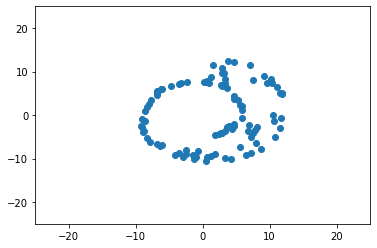

In [126]:
plt.scatter(projection3[:,0], projection3[:,2])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('roll_replication')

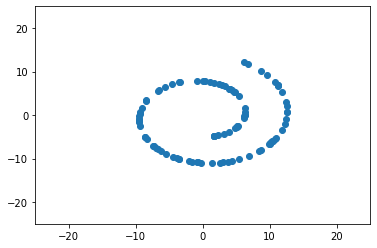

In [127]:
plt.scatter(TARGET3[:,0], TARGET3[:,2])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('roll_original')

NOTE: try increasing the number of controls: the current setup has too few controls that are very different from each other. The weight being almost half will cause the projection to be off.

## (4) Binary Data

In [30]:
bin1 = np.column_stack((np.random.randint(2, size = 100), 
                        np.random.randint(2, size = 100), 
                        np.random.randint(2, size = 100)))
bin2 = np.column_stack((np.random.randint(2, size = 100), 
                        np.random.randint(2, size = 100),
                        np.random.randint(2, size = 100)))
bin3 = np.column_stack((np.random.randint(2, size = 100), 
                        np.random.randint(2, size = 100),
                        np.random.randint(2, size = 100)))
controls4 = [bin1, bin2, bin3]

TARGET4 = np.column_stack((np.random.randint(2, size = 100), 
                           np.random.randint(2, size = 100),
                           np.random.randint(2, size = 100)))

In [31]:
weights4, projection4 = DSCreplicationV2(TARGET4, controls4)
projection4rnd = projection4.round(decimals = 0).astype('int64')

/Users/pablomjlee/miniforge3/lib/python3.9/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [32]:
projection4rnd[0:5,:]

array([[0, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 1, 1]])

In [33]:
TARGET4[0:5,:]

array([[0, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 1, 1]])

In [35]:
#projection4rnd == TARGET4

Q: At what point do we want to round?<br>
Q: how to implement this for data mixed between binary and continuous<br>
Q: convergence issues: might be fine for 100+ samples

# TO DO

* Finalize naming of variables and functions
* Test for histograms and for different sizes of controls -- if needed, generalize
* Testing with real-life data(Medicaid, Image data)

# Questions
* mixed gaussian example in paper: make obvious like one here, or make it more realistic? -- plottable